# Introduction to ORCA model output

I hope this helps as a start to work with the ORCA model output, which can be a little confusing to begin with.  
Here a link to the general NEMO manual: https://www.nemo-ocean.eu/doc/

The model is run on an Arakawa-C grid ,which means that e.g. temperature and salinity are definited at the center of a grid cell and velocities at the edges of the grid cells (see the NEMO manual for more detailed information https://www.nemo-ocean.eu/doc/node19.html)  

Furthermore, our runs are based on the ORCA (tripolar) grid, which means that we cannot represent latitude and longitude as one-dimensional vectors but need two-dimensional fields since the grid cells north of 30N are not regular size anymore (https://www.nemo-ocean.eu/doc/node108.html). 

Mention XORCA and XGCM!

In [1]:
# load all necessary packages and functions. Their is a best practices guide regarding the order that
# you load things to keep it consistent - I haven't managed to be that organize yet ;-) 

%matplotlib inline

import sys
sys.path.append("..")  # adds upper level to working directory, this is where the utils folder is saved

import numpy as np 
import xarray as xr
import datetime as dt

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cmocean as cmo  # cmocean colormaps
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy   # package to plot maps
import cartopy.crs as ccrs

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# load my own functions
from utils.plot_utils import plot_map
from utils.data_utils import mask_shelf,mask_box,load_oisst
from utils.orca_utilities import load_mesh,cut_latlon_box

# Load data

You will have to adjust the path to clidex, depening on how it is mounted on your computer.

In [2]:
# load data into xarray
run = 'K003.hindcast'
temp = xr.open_dataset('/vortex/clidex/data/ORCA/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2_processed_NWA/' + run +
                                '_1957_2016_temp_grid_T_full.nc')
sal = xr.open_dataset('/vortex/clidex/data/ORCA/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2_processed_NWA/' + run +
                                '_1957_2016_sal_grid_T_full.nc')

# check out structure of xarray
print(temp)

# values on land are zero --> set to nan
temp = temp.where(temp['votemper']!=0)
sal = sal.where(sal['vosaline']!=0)

<xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 24, time_counter: 708, x: 184, y: 157)
Coordinates:
  * time_counter       (time_counter) datetime64[ns] 1958-01-16T12:00:00 ... 2016-12-16T12:00:00
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * deptht             (deptht) float32 3.0467727 9.454049 ... 855.1112 989.2289
Dimensions without coordinates: bnds, x, y
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] ...
    deptht_bnds        (deptht, bnds) float32 ...
    votemper           (time_counter, deptht, y, x) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.6 (http://m...
    history:                   Fri Jun 12 17:43:35 2020: cdo merge K003.hindc...
    Conventions:               CF-1.6
    name:                      _OUT/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003....
    description:               ocean T grid variables
    title:                     ocean T grid v

As you can see, xarray does not just load the variables in the dataset but also keeps all the meta information.

Because of the fact that we have 2D latitude and longitude fields, which are names nav_lon & nav_lat, our dimensions are simply called x and y. If we had 1D latitude and longitude vectors our dimensions would be called the same. However, now they represent indices rather than actual latitude and longitude values.

# Plot a map

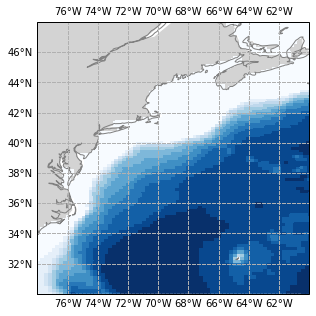

In [3]:
# try function to plot map with bathymetry
fig,ax = plot_map(figsize=[6,5])

I wrote this function as a little helper. You can look into the file plot_utils.py in the utils folder and look at what plot_map does there.

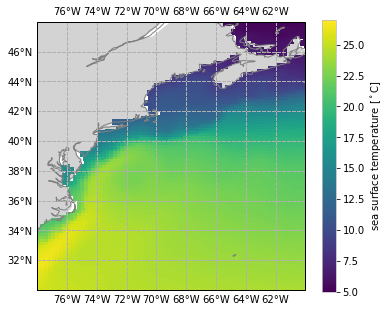

In [5]:
# plot a map with surface temperature

# call map function
fig,ax = plot_map(figsize=[6,5]) # this plots a basic map of the region. You can use the handles fig & ax to plot on top of that

# plot time-mean surface temperature
cc = ax.pcolor(temp.nav_lon,temp.nav_lat,temp['votemper'].isel(deptht=0).mean('time_counter'),vmin=5,vmax=27)
plt.colorbar(cc, label='sea surface temperature [$^\circ$C]')

# Apply mask for shelf

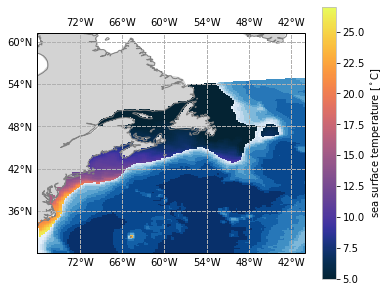

In [6]:
# apply mask so that only temperature on shelf is shown

mask_sh = np.squeeze(mask_shelf(depth=500))  # all values deeper than given depth will be 0
temp_shelf = temp.where(mask_sh[0,::]==1)

# call map function
fig,ax = plot_map(figsize=[6,5]) # this plots a basic map of the region. You can use the handles fig & ax to plot on top of that
ax.set_extent([-78,-40,30,60])   # modifiy spatial extend

# plot time-mean surface temperature
cc = ax.pcolor(temp.nav_lon,temp.nav_lat,
               temp_shelf['votemper'].isel(deptht=0).mean('time_counter'),
               vmin=5,vmax=27, cmap = plt.get_cmap('cmo.thermal'))
plt.colorbar(cc,label='sea surface temperature [$^\circ$C]')

This will be helpful since we are particularly interested in temperatures on the shelf.  

We can see that our data only goes up to 54N (they were cut to reduce file size)

# Spatial averaging

Because of earth's shape and the design of the grid, grid cells do not represent the same area/volume. The most simple
example: 1deg longitude at the equator is roughly 110km long while 1deg longitude at 45N represents only about 78km (scale by cosine of the latitude):

In [7]:
110*np.cos(np.deg2rad(45))

77.78174593052023

Models come with mesh files that provide the necessary information for each grid cell. These mostly become important for us when we want to for example derive an average over multiple grid cells (horizontal and/or vertical) or if we want to calculate volume transports.  

In addition to the information of the size of grid cells, a mask file provides information about which grid cells represent land and which represent ocean.

I wrote a function that reads the mesh & mask files

In [16]:
# Prepare for averaging

# load mesh files
meshz,meshh,mask = load_mesh('NWA')

# check horizontal mesh file
print(meshh)

<xarray.Dataset>
Dimensions:       (t: 1, x: 184, y: 157, z: 24)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    glamt         (t, y, x) float32 ...
    glamu         (t, y, x) float32 ...
    glamv         (t, y, x) float32 ...
    glamf         (t, y, x) float32 ...
    gphit         (t, y, x) float32 ...
    gphiu         (t, y, x) float32 ...
    gphiv         (t, y, x) float32 ...
    gphif         (t, y, x) float32 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e1f           (t, y, x) float64 ...
    e2t           (t, y, x) float64 ...
    e2u           (t, y, x) float64 ...
    e2v           (t, y, x) float64 ...
    e2f           (t, y, x) float64 ...
    ff            (t, y, x) float64 ...


e1t and e2t are your horizontal weights for all variables on the T-grid, one for the meridional and one for zonal direction. Thus the area of a cell would be given by e1t*e2t

In [13]:
####################
# some functions that will make life easier (will add these to the utils folder ultimately, but this also gives
# you an example of how to define and use functions)
#
#--------------------------------------------------------------------------
# derive weighted mean if weights are provides, normal mean otherwise
def mean_weighted(self, dim=None, weights=None):
    if weights is None:
        return self.mean(dim)
    else:
        return (self * weights.values).sum(dim,skipna=True) / weights.sum(dim,skipna=True)
#
#
# cut box with 2D coordinates
def cut_latlon_box(field,lon,lat,lon_bnds,lat_bnds,drop=True,coords='2D'):
        # ### cut data for box
        if coords=='2D':
            ds = field.where((lon_bnds[0] < lon) & (lon < lon_bnds[1])
                     & (lat_bnds[0] < lat) & (lat < lat_bnds[1]), drop=drop)
            # because we have 2D coordinates we have to use the command where, otherwise we could use the
            # sel & slice commands from xarray
        elif coords=='1D':
            ds = field.sel(lon=slice(*lon_bnds),lat=slice(*lat_bnds),drop=drop)
        return ds

In [9]:
# plot time series over shelf between 36N and 44N

# first cut data between these two latitudes and average.
xbnds = [-80,-65]
ybnds = [36,44]

# Need weights as grid cell do not always have the same size 
area = np.squeeze(meshh['e1t']*meshh['e2t']).where(mask_sh[0,::]==1)  # squeeze eliminates time dimension which was only 1 
area = cut_latlon_box(area,meshh.nav_lon,meshh.nav_lat,xbnds,ybnds,drop=True)

# cut temp field and apply weights
temp_ave = cut_latlon_box(temp_shelf['votemper'],temp.nav_lon,temp.nav_lat,xbnds,ybnds,drop=True)
temp_wave = mean_weighted(temp_ave,dim=('x','y'),weights=area.where(np.isfinite(temp_ave[0,0,::])))

Make sure that each step is doing what it is supposed to do! It helps to plot the individual fields and then compare weighted vs non-weighted time series.

Text(0.5, 1.0, 'Difference (weighted minus non-weighted)')

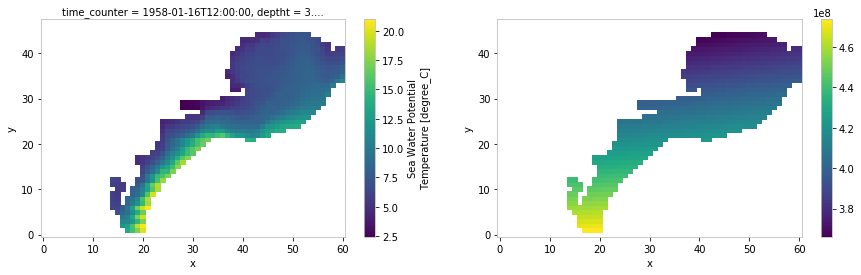

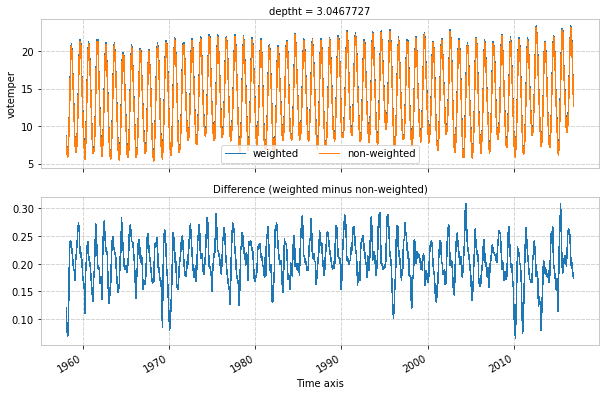

In [10]:
# plot weights and cut temp field to make sure they cover the same region and shelf only
fig,ax = plt.subplots(figsize=(15,4),ncols=2)
temp_ave[0,0,::].plot(ax=ax[0])
(area).plot(ax=ax[1])

# weighted vs. non-weighted time series
fig,ax = plt.subplots(figsize=(10,6),sharex=True,nrows=2)
temp_wave[:,0].plot(ax=ax[0],label='weighted')
(temp_ave)[:,0,::].mean(('x','y')).plot(ax=ax[0],label='non-weighted')
ax[0].legend(ncol=2)
ax[0].set_xlabel('')

# difference
(temp_wave[:,0]-(temp_ave)[:,0,::].mean(('x','y'))).plot(ax=ax[1])
ax[1].set_title('Difference (weighted minus non-weighted)')

We can see that applying the weights made a small but noticable difference! It makes sense that the weighted mean time series yields higher temperatures, as the warm grid cells in the south are weighted higher due to their larger size.